In [1]:
x=1

In [ ]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import os
import scipy
import scipy.io
import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

import seaborn as sns
import matplotlib.pyplot as plt

from rpy2.robjects import r
from rpy2.robjects import pandas2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

## Load datasets

In [ ]:
multiom = ad.read_h5ad("GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")
multiom

In [ ]:
multiom_ref = multiom[multiom.obs['Site'].isin(['site1', 'site2'])].copy() #select site1 and site2 as a reference
multiom_ref

In [ ]:
atac = multiom_ref[:, multiom_ref.var['feature_types'] == 'ATAC'].copy()
rna_multiom = multiom_ref[:, multiom_ref.var['feature_types'] == 'GEX'].copy()
atac, rna_multiom

In [ ]:
assert np.sum(rna_multiom.obs_names != atac.obs_names) == 0 #we make sure that cells are the same in multiome data

In [ ]:
cite = ad.read_h5ad("GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")
cite

In [ ]:
cite_ref = cite[cite.obs['Site'].isin(['site1', 'site2'])].copy() #select site1 and site2 as a reference
cite_ref

In [ ]:
adt = cite_ref[:, cite_ref.var['feature_types'] == 'ADT'].copy()
rna_cite = cite_ref[:, cite_ref.var['feature_types'] == 'GEX'].copy()
adt, rna_cite

In [ ]:
assert np.sum(rna_cite.obs_names != adt.obs_names) == 0 #we make sure that cells are the same in cite data

## Integrate rna_multiom and rna_cite together

In [ ]:
rna = rna_multiom.concatenate(rna_cite, batch_key='concat_key', index_unique=None)
rna

In [ ]:
sc.pp.highly_variable_genes(rna, n_top_genes=4000, batch_key='Samplename')
rna = rna[:, rna.var.highly_variable]
rna

In [ ]:
rna.write("rna_concat.h5ad")

## WNN Integrate RNA_multiom and RNA_cite

In [4]:
ref = ad.read_h5ad("rna_concat.h5ad")
ref

AnnData object with n_obs × n_vars = 73951 × 4000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'GEX_n_genes_by_counts', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'ADT_pseudotime_order', 'is_train', 'concat_key'
    var: 'feature_types', 'gene_id-0', 'gene_id-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p'
    obsm: 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [6]:
adata_ = ad.AnnData(ref.layers['counts'].A)
adata_.obs_names = ref.obs_names
adata_.var_names = ref.var_names
adata_.obs['celltype'] = ref.obs['cell_type']
adata_.obs['batch'] = ref.obs['Samplename']
adata_.obs['site'] = ref.obs['Site']

In [5]:
%%R
library(Seurat)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [6]:
%%R
options(Seurat.object.assay.version = 'v5')

In [9]:
%%R -i adata_
ref <- as.Seurat(adata_, data=NULL, counts='X')
ref <- RenameAssays(object = ref, originalexp = "RNA")
ref

An object of class Seurat 
4000 features across 73951 samples within 1 assay 
Active assay: RNA (4000 features, 0 variable features)
 2 layers present: counts, data


In [10]:
%%R
# split the dataset into a list of seurat objects according to batches
ref.list <- SplitObject(ref, split.by = "batch")
ref.list

$site1_donor1_multiome
An object of class Seurat 
4000 features across 6224 samples within 1 assay 
Active assay: RNA (4000 features, 0 variable features)
 2 layers present: counts, data

$site1_donor2_multiome
An object of class Seurat 
4000 features across 6740 samples within 1 assay 
Active assay: RNA (4000 features, 0 variable features)
 2 layers present: counts, data

$site1_donor3_multiome
An object of class Seurat 
4000 features across 4279 samples within 1 assay 
Active assay: RNA (4000 features, 0 variable features)
 2 layers present: counts, data

$site2_donor1_multiome
An object of class Seurat 
4000 features across 4220 samples within 1 assay 
Active assay: RNA (4000 features, 0 variable features)
 2 layers present: counts, data

$site2_donor4_multiome
An object of class Seurat 
4000 features across 6111 samples within 1 assay 
Active assay: RNA (4000 features, 0 variable features)
 2 layers present: counts, data

$site2_donor5_multiome
An object of class Seurat 
4000 featu

In [ ]:
%%R
ref.list <- lapply(X = ref.list, FUN = SCTransform)

  |                                                                      |   0%

In [ ]:
%%R
ref.list <- lapply(X = ref.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 4000)
})

In [ ]:
%%R
features <- SelectIntegrationFeatures(object.list = ref.list)

In [15]:
%%R
anchors <- FindIntegrationAnchors(object.list = ref.list, anchor.features = features)

  |                                                  | 0 % ~calculating   |+++++                                             | 8 % ~04s           |+++++++++                                         | 17% ~04s           |+++++++++++++                                     | 25% ~03s           |+++++++++++++++++                                 | 33% ~02s           |+++++++++++++++++++++                             | 42% ~02s           |+++++++++++++++++++++++++                         | 50% ~02s           |++++++++++++++++++++++++++++++                    | 58% ~01s           |++++++++++++++++++++++++++++++++++                | 67% ~01s           |++++++++++++++++++++++++++++++++++++++            | 75% ~01s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++    | 92% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=04s  
  |                                                  | 0 % ~ca

In [16]:
%%R
ref.combined <- IntegrateData(anchorset = anchors)

In [17]:
%%R
DefaultAssay(ref.combined) <- "integrated"

In [18]:
%%R
ref.combined <- ScaleData(ref.combined, verbose = FALSE)

In [19]:
%%R
ref.combined <- RunPCA(ref.combined, verbose = TRUE)

In [20]:
%%R
ref.combined <- RunUMAP(ref.combined, reduction = "pca", dims = 1:30, return.model=TRUE)

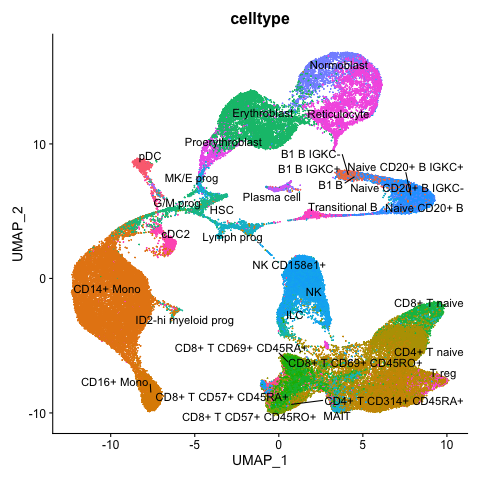

In [21]:
%%R
p2 <- DimPlot(ref.combined, reduction = "umap", group.by = "celltype", label = TRUE, repel = TRUE) + NoLegend()
p2

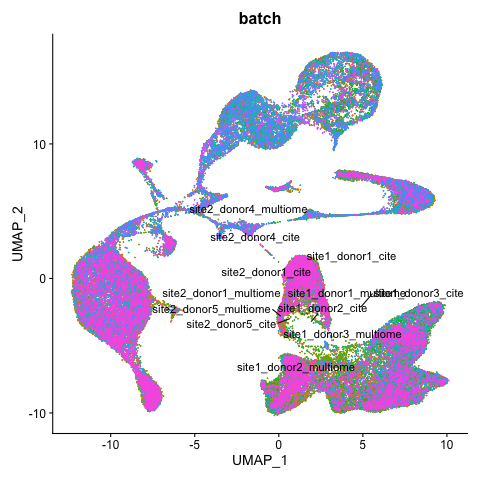

In [35]:
%%R
p3 <- DimPlot(ref.combined, reduction = "umap", group.by = "batch", label = TRUE, repel = TRUE) + NoLegend()
p3

In [23]:
%%R
saveRDS(ref.combined, file = "bridge_ref.rds")